*Project Goal: Can machine learning produce higher returns while investing in Marketplace loans.*

**Marketplace Lending Project: Part 1 -  Overview and Data Discovery**

 - Marketplace Lending landscape 
 - Data Discovery
 - Data Cleaning
 - Featured Engineering
 - Exploratory Data Analysis (EDA)
 - EDA: Conclusion

**Marketplace Lending Project: Part 2 - Building The Machine Learning Model**

 - Data prepocessing
 - Dealing with an imbalanced dataset  
 - Building the model
 - Evaluating the model
 - Month by month model training and prediction
 - Month by month model evaluating
 
**Marketplace Lending Project: Part 3 - Time Simulation**

- Coming soon

**Marketplace Lending Project: Part 4 - Proeject Review and Whats Next**

- Coming soon
 

Load cleaned data from saved HDF5 file

In [2]:
#Load in the cleaned Data
import pandas as pd
import numpy as np
model_df = pd.read_hdf('model_df.h5', key='df')

### Data prepocessing:

Data preprocessing and cleaning takes time but is arguably the most important piece. If done incorrectly, it could have significant ramifications on model results. Preprocessing is preparing the data for the algorithms. This is done in several steps.

**Updating Variables:** Since Machine Learning models cannot handle categorical data, categories need to be converted into binary dummy variables. For example, grades A, B, and C would translate to columns grade_A, grade_B, and grade_C. 

**Removing data:** Columns that either contain ancillary information or not be present at time of investment need to be removed. To preserve the data, converting loan ID to the index allows the datasets to be merged after running the ML model. 

In [2]:
lending_club_data = model_df

todummy_list = ['sub_grade', 'grade', 'purpose', 'home_ownership', 'disbursement_method']


def dummy_df(lending_club_data, todummy_list):
        for x in todummy_list:
            dummies = pd.get_dummies(lending_club_data[x], prefix=x, dummy_na=False)
            lending_club_data = lending_club_data.drop(x, 1)
            lending_club_data = pd.concat([lending_club_data, dummies], axis=1)
        return lending_club_data

lending_club_data = dummy_df(lending_club_data, todummy_list) #Create Dummy Variables:

lending_club_data = lending_club_data.set_index('id') #Set index to Loan ID

columns_to_drop = ['issue_d'] 

lending_club_data = lending_club_data.drop(columns_to_drop, 1)#Drop issue date

lending_club_data = lending_club_data.dropna(subset=['loan_status']) #drop na from loan status

**Imputing missing Variables:** The Lending Club data has many columns that contain missing values. ML estimators cannot compute missing values as models assume each value is numeric and holds value. To correct for this, Sklearn imputer will fill missing values by inferring value based on present column data. 


In [3]:
# imputer
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=1)

imp.fit(lending_club_data)
lending_club_data = pd.DataFrame(data=imp.transform(lending_club_data),
                                     columns=lending_club_data.columns)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Dealing with an imbalanced dataset  

In [4]:
import altair as alt

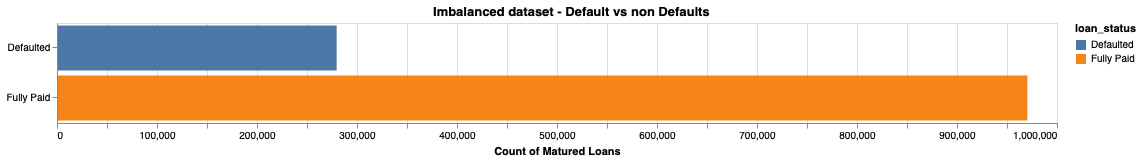

In [5]:
chart_blance_data = lending_club_data.groupby(['loan_status'])['loan_amnt'].count().reset_index()

map_default_status = {0:'Defaulted', 1:'Fully Paid'}

chart_blance_data['loan_status'] = chart_blance_data['loan_status'].map(map_default_status)

alt.Chart(chart_blance_data).mark_bar().encode(
    y=alt.Y(field='loan_status',type='nominal',axis=alt.Axis(title='')),
    x=alt.X(field='loan_amnt',type='quantitative',axis=alt.Axis(title='Count of Matured Loans')),
    tooltip=['loan_status:N', 'loan_amnt'],
    color='loan_status:N').properties(width=1000, height=100,title='Imbalanced dataset - Default vs non Defaults')

**imbalanced data:** The majority of Lending Club loans are fully paid creating an imbalanced data set as seen in the above graph. While Machine Learning models can have difficulty training on imbalanced datasets, oversampling the minority class and making class weights equal is an effective strategy to counter this. This can lead to overfitting, however in this project oversampling significantly improved results and did not appear to cause overfitting. 

In [6]:
#ensure equal classes
value_counts = lending_club_data.loan_status[lending_club_data.loan_status == 1].count()

#to ensure that only the default/matured loans are in the dataframe
default = lending_club_data[lending_club_data.loan_status == 0]
non_default = lending_club_data[lending_club_data.loan_status == 1]

#Adjust the numer of samples
default_sample = default.sample(n=value_counts, replace=True)
non_default_sample = non_default.sample(n=value_counts, replace=True)

#combine the two data sets
equal_def_non_def = default_sample.append(non_default_sample)

shuffle data - After combining the data it is important to randomize the default and non default loans

In [7]:
#shuffle
from sklearn.utils import shuffle

equal_def_non_def = shuffle(equal_def_non_def)

data = equal_def_non_def

### Building the model

After using several classification models, the random forest proved best results without giving way to overfitting. 

Side Note: Once I finish this project I plan to try various deep learning algorithms to see if better results can be achieved. Also, instead of trying to predict whether or not a loan will default, which I will explore in a future post 


In [8]:
from sklearn.model_selection import train_test_split
# prepare data
#data = lending_club_data

X = data.drop('loan_status', 1)
y = data.loan_status

# test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [9]:
#Train Model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
        class_weight="balanced",
        bootstrap = False,
        n_estimators=75,
        n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Evaluating the model

The machine learning model achieved an accuracy score of 94.2%, though it oversampled the minority class. By looking at both the confusion matrix and the model scores we can conclude the model is accurately predicting defaults. The model was built using historical data, but how will it hold up on future predictions?


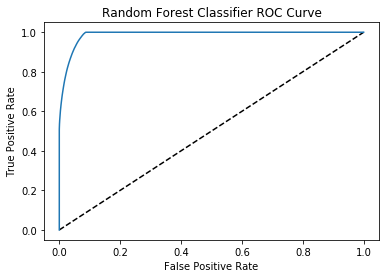

Model score: 0.9424956289052168
classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    290606
         1.0       0.94      0.94      0.94    291628

   micro avg       0.94      0.94      0.94    582234
   macro avg       0.94      0.94      0.94    582234
weighted avg       0.94      0.94      0.94    582234



In [10]:
#Evaluate Model 
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

y_pred = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
#plot results
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
plt.show();

#show results
print("Model score:",(model.score(X_test, y_test)))
print("classification Report:")
print(classification_report(y_test, y_pred))

Confusion matrix, without normalization
[[273896  16710]
 [ 16771 274857]]


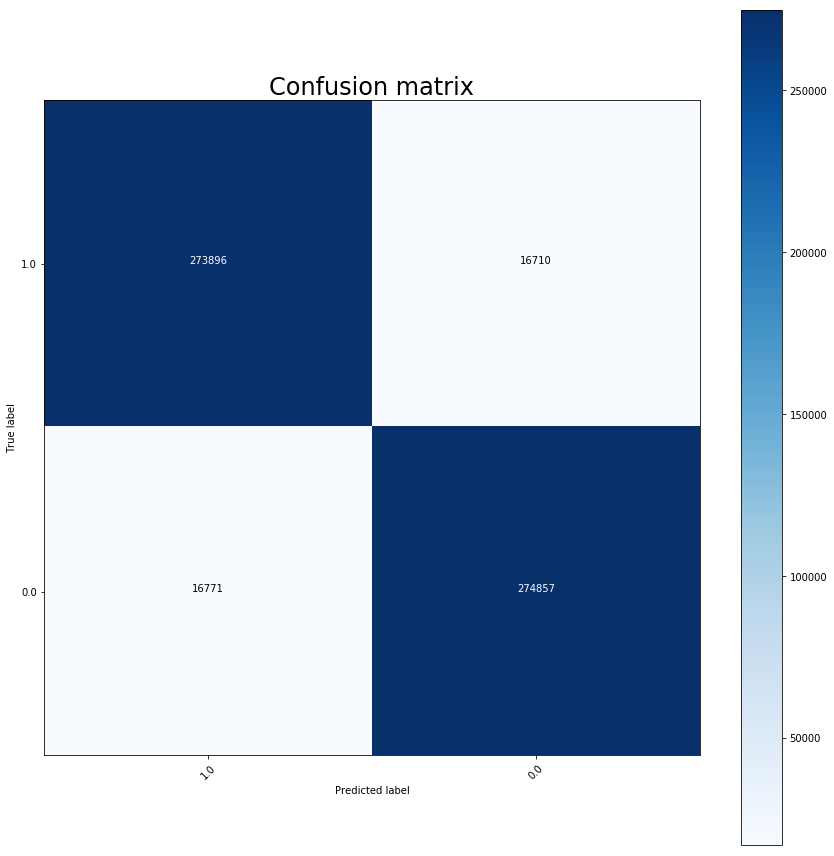

In [11]:
import itertools
from itertools import cycle

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.grid(b=False)
    plt.tight_layout()
    plt.ylabel('True label', size=10)
    plt.xlabel('Predicted label', size=10)

np.set_printoptions(precision=2)

cnf_mtx = confusion_matrix(y_test, y_pred)
class_names = data.loan_status.unique()

plot_confusion_matrix(cnf_mtx, classes=class_names,
                      title='Confusion matrix')

plt.show()

In [12]:
_feature_importances = pd.DataFrame({'coef':model.feature_importances_, 'features':X_train.columns}).sort_values('coef', ascending=False).head(25)

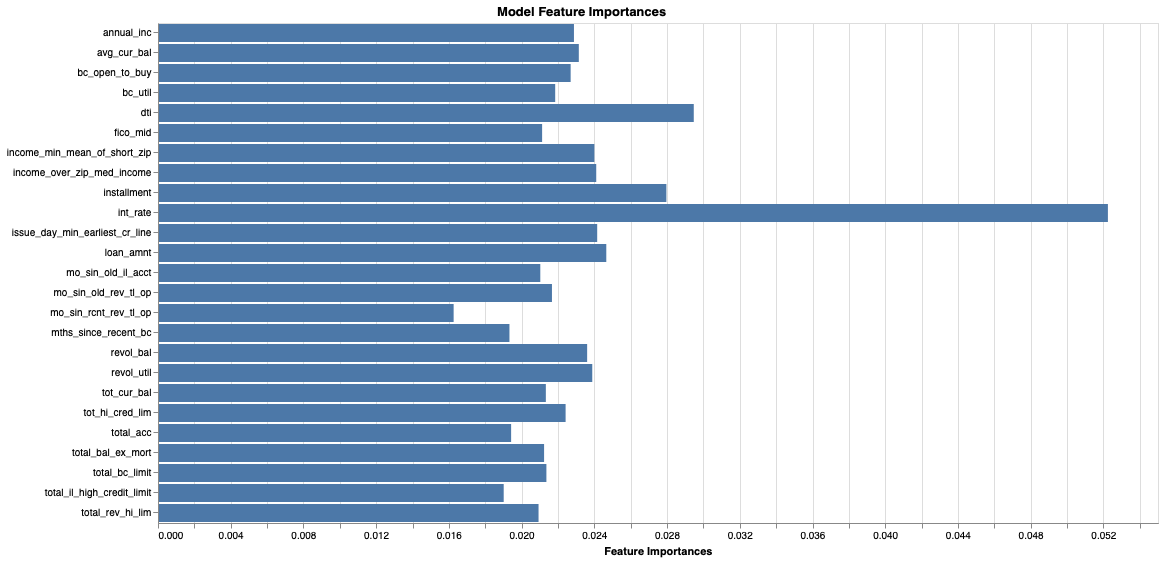

In [13]:
alt.Chart(_feature_importances).mark_bar().encode(
    y=alt.Y(field='features',type='nominal',axis=alt.Axis(title='')),
    x=alt.X(field='coef',type='quantitative',axis=alt.Axis(title='Feature Importances')),
    tooltip=['coef:N', 'features']
).properties(width=1000, height=500,title='Model Feature Importances')

### Month by month model training and prediction:

To test the model, the environment needs to resemble the real world. To do this, the model is run on historical data which then predicts the outcome on new data. Starting in 2009, with two years of data, the model runs each month predicting the defaults on the following months loans. For each month, it predicts the probability of default and returns model scores. This data will be used in my next post when adding an investment strategy. 

In [17]:
model_df = pd.read_hdf('model_df.h5', key='df')

In [18]:
model_df.dropna(subset=['issue_d'], how='all', inplace = True)

#Get list of all moths 
month_list = model_df.issue_d.unique()
month_list.sort()
month_list = month_list[5:] # starting from 2009

In [19]:
#Same as before, clean and prepare data

lending_club_data = model_df

lending_club_data = lending_club_data.dropna(subset=['loan_status'])

todummy_list = ['sub_grade', 'grade', 'purpose', 'home_ownership', 'disbursement_method']

def dummy_df(lending_club_data, todummy_list):
        for x in todummy_list:
            dummies = pd.get_dummies(lending_club_data[x], prefix=x, dummy_na=False)
            lending_club_data = lending_club_data.drop(x, 1)
            lending_club_data = pd.concat([lending_club_data, dummies], axis=1)
        return lending_club_data

lending_club_data = dummy_df(lending_club_data, todummy_list)

#the imputer does not accept date variables
columns_to_drop = ['issue_d']
lending_club_data = lending_club_data.drop(columns_to_drop, 1)

# imputer
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=1)

imp.fit(lending_club_data)
lending_club_data = pd.DataFrame(data=imp.transform(lending_club_data),
                                     columns=lending_club_data.columns)

#Add back date after imputer
date_add_back = model_df[['issue_d','id']]
date_add_back['id'] = date_add_back.id.astype(float)

lending_club_data = lending_club_data.merge(date_add_back[['issue_d','id']], on='id', how='left')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
#model Train:
def model_train(lending_club_data):
    """
    Input: Cleaned lending club data 
    Operations: Normalizes data, runs random forest model, Calculates model score
    Output: Dictionary  of Trained model, model score, precision score, roc auc score, and  f1 score
    """
    from sklearn.utils import shuffle
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
    
    lending_club_data = lending_club_data.set_index('id')
    
    columns_to_drop = ['issue_d']
    lending_club_data = lending_club_data.drop(columns_to_drop, 1)
    
    #ensure equal classes
    value_counts = lending_club_data.loan_status[lending_club_data.loan_status == 1].count()
    #to ensure that only the default/matured loans are in the dataframe
    default = lending_club_data[lending_club_data.loan_status == 0]
    non_default = lending_club_data[lending_club_data.loan_status == 1]

    #Adjust the numer of samples
    default_sample = default.sample(n=value_counts, replace=True)
    non_default_sample = non_default.sample(n=value_counts, replace=True)

    #combine the two data sets
    equal_def_non_def = default_sample.append(non_default_sample)
    
    #shuffle
    equal_def_non_def = shuffle(equal_def_non_def)

    data = equal_def_non_def
    
    # prepare data

    X = data.drop('loan_status', 1)
    y = data.loan_status

    # test train split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=1)
    
    #train model
    model = RandomForestClassifier(
            class_weight="balanced",
            bootstrap = False,
            n_estimators=75,
            n_jobs=-1)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #evaluate model
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    model_score = model.score(X_test, y_test)
    
    precision_score = precision_score(y_test, y_pred, 'weighted')
    roc_auc_score = roc_auc_score(y_test, y_pred, 'weighted')
    f1_score = f1_score(y_test, y_pred, 'weighted')
    
    model_dict = {'model':model, 
                  'model_score': model_score, 
                  'precision_score':precision_score, 
                  'roc_auc_score': roc_auc_score, 
                  'f1_score': f1_score}
    
    return model_dict

In [21]:
#model Predict
def model_predict(data, model):
    """
    Input: Lending club data, trained model
    Operations: Uses trained model to make predictions on lending club data
    Output: Data with default probabilities 
    """
    
    loan_ID = data.id
    date_add_back = data.issue_d
    
    columns_to_drop = ['issue_d', 'id']
    data = data.drop(columns_to_drop, 1)
    
    X_data = data.drop('loan_status', 1)
    Y_data = data.loan_status
    
    data['proba'] = model.predict_proba(X_data)[:, 1]
    data['loan_status'] = Y_data
    data['loan_ID'] = loan_ID
    data['issue_d'] = date_add_back
    return data

In [22]:
def month_by_month_prediction(month_list, lending_club_data):
    """
    Input: Month list, lending club data
    Operations: predicts default probability on each month in month list and computes model score
    Output: data with default probability monthly model scores
    """
    full_data_set = pd.DataFrame()
    for month in month_list:
        
        #filter out future months including month being tested
        training_data = lending_club_data[lending_club_data.issue_d < month]
        
        #Traine model:
        trained_model_dict = model_train(training_data)
        
        #return evaluation metrics
        model = trained_model_dict.get('model')
        model_score = trained_model_dict.get('model_score')
        precision_score = trained_model_dict.get('precision_score')
        roc_auc_score = trained_model_dict.get('roc_auc_score')
        f1_score = trained_model_dict.get('f1_score')
        
        #predict on month being tested
        predict_data = lending_club_data[lending_club_data.issue_d == month]
        predicted_df = model_predict(predict_data, model)
        
        #add model info
        predicted_df['model_score'] = model_score
        predicted_df['precision_score'] = precision_score
        predicted_df['roc_auc_score'] = roc_auc_score
        predicted_df['f1_score'] = f1_score
        
        #append data for each month
        full_data_set = full_data_set.append(predicted_df)
    return full_data_set

In [23]:
dataset_monthly_predictions = month_by_month_prediction(month_list, lending_club_data)

In [24]:
model_df['loan_ID'] = model_df.id.astype(float)

In [25]:
dataset_monthly_predictions = dataset_monthly_predictions.merge(model_df[['grade',
                                                                          'sub_grade',
                                                                          'loan_ID']], on='loan_ID', how='left')

In [26]:
dataset_monthly_predictions.to_hdf('dataset_monthly_predictions.h5', key='df') # save data

In [51]:
dataset_monthly_predictions = pd.read_hdf('dataset_monthly_predictions.h5', key='df')

### Month by month evaluating

Model scores saw slight fluctuations over time but never dropped below 92% accuracy. Also, looking at the Predicted Non-Default Probability Vs True Loan Status graph, this model can accurately be used to predict what loans are less likely to default. 

In [28]:
model_performance = dataset_monthly_predictions.groupby(['issue_d','model_score',
                                                         'precision_score',
                                                         'roc_auc_score','f1_score'])[
                                                                            'loan_ID'].count().reset_index()

df = pd.melt(model_performance, id_vars=['issue_d'], value_vars=['model_score', 'precision_score','f1_score' ])

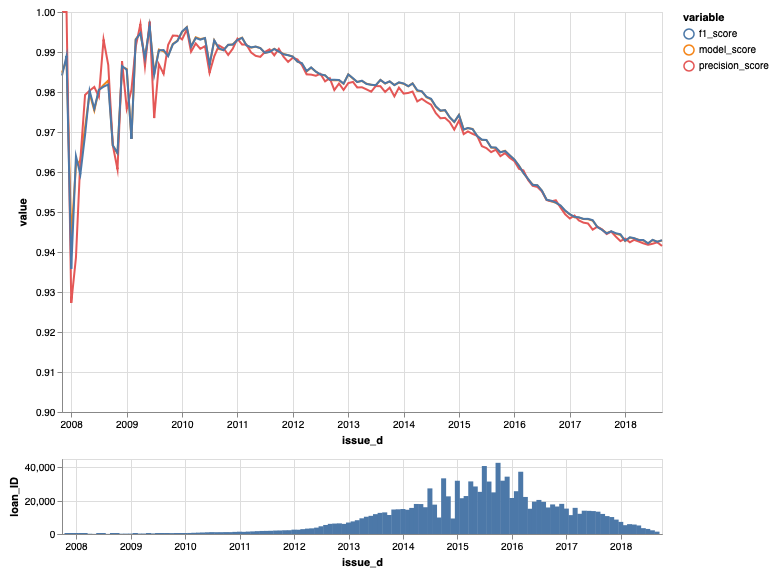

In [30]:
chart_1 = alt.Chart(df).mark_line().encode(
    x='issue_d',
    y=alt.Y(field='value',type='quantitative',scale=alt.Scale(domain=[.9, 1])),
    color = 'variable'
).properties(width=600, height=400)

chart_2 = alt.Chart(model_performance).mark_bar().encode(
    x='issue_d',
    y=alt.Y(field='loan_ID',type='quantitative')
).properties(width=600, height=75)

chart_1 & chart_2

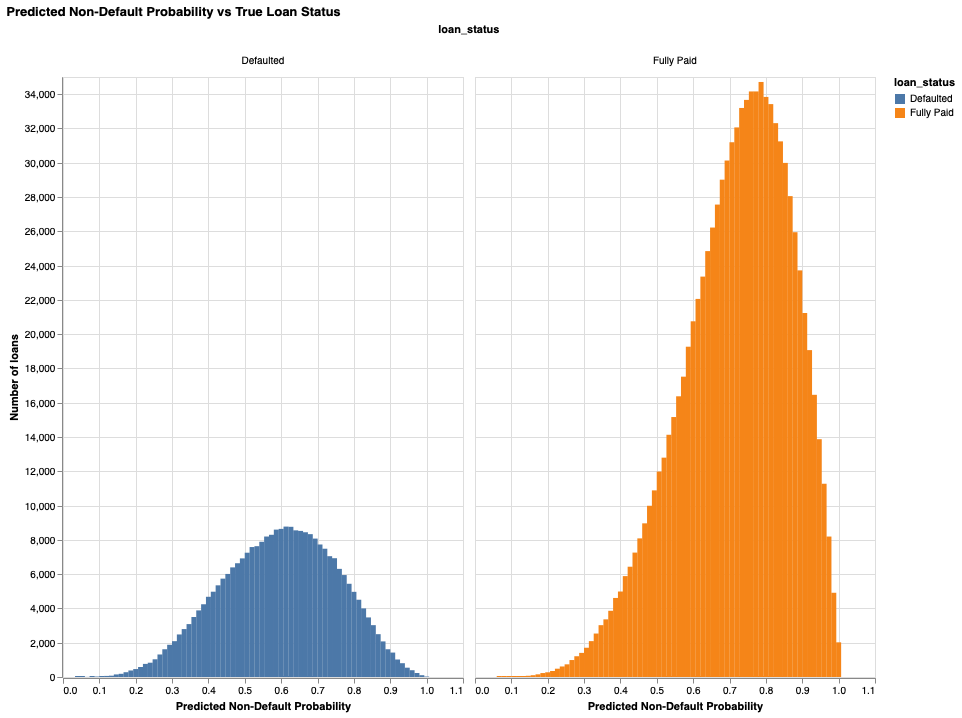

In [52]:
import altair as alt

model_predictions =  dataset_monthly_predictions

map_default_status = {0:'Defaulted', 1:'Fully Paid'}

model_predictions['loan_status'] = model_predictions['loan_status'].map(map_default_status)

model_predictions = model_predictions.groupby(['proba','loan_status'])['loan_ID'].count().reset_index()

alt.Chart(model_predictions).mark_bar().encode(
    x=alt.X(field='proba',type='quantitative',axis=alt.Axis(title='Predicted Non-Default Probability')),
    y=alt.Y(field='loan_ID',type='quantitative',axis=alt.Axis(title='Number of loans')),
    column='loan_status:N',
    color='loan_status:N'
).properties(width=400, height=600,title='Predicted Non-Default Probability vs True Loan Status')